In [74]:
using Revise
using Pkg; Pkg.activate(".")

using Dates
using Statistics # limited set of methods included in Julia Base
using StatsBase  # extends Statistics with more functions
using Rotations
using FFTW
# using SignalAlignment
using Interpolations
using PyPlot
using JLD2
# using MAT

include("./readers.jl")
using .ShipPosmv

include("./read_lidar.jl")
using .read_vecnav: read_vecnav_dict

include("./timing_lidar.jl")
using .timing_lidar

  Activating project at `~/Projects/ASTRAL/lidar`


In [40]:
# helper functions
pd = permutedims
m2n(x) = ismissing(x) ? NaN : x

anom(x; dims=1) = x .- mean(x; dims=dims)

# functional wrapper for PyPlot plot
plotf(f::Function, x, va...) = plot(x, f.(x), va...)

plotf (generic function with 1 method)

In [2]:
# rotations example

# RotXY(roll, pitch) # radians
# matrix that rotates around y (pitch), then by x (roll) in radians
RotXY(10/180*pi, 5/180*pi)

3×3 RotXY{Float64} with indices SOneTo(3)×SOneTo(3)(0.174533, 0.0872665):
  0.996195   0.0        0.0871557
  0.0151344  0.984808  -0.172987
 -0.0858317  0.173648   0.98106

Use `RotXY(ϕ, θ)` when there is no stabilization; i.e., the lidar is strapped down to the deck, as in the first part of EKAMSAT leg 2.


In the second part of EKAMSAT leg 2, the stabilization was working only for the roll axis.
The pitch axis was strapped, so we can synchronize using the pitch angle as in `vectornav.ipynb`.
To start, assume the pitch gimbal is strapped level to the ship deck (there might be a small offset angle).
If the roll stabilization works well, then the lidar coordinate system is rotated only by the pitch angle about the y axis.
Use `RotY(θ)` for this rotation matrix.

For leg 1 we assume it's fully stabilized, so we can measure the difference between the heave at the lidar and at the POSMV.
The heave measured by the POSMV is assumed to be vertical, and the heave at the VectorNav on the lidar, is also vertical when stabilized.
In this case, the displacement moments $(L_x, L_y, L_z)$ between the lidar and the POSMV are responsible for the difference in heave vertical velocity at the lidar $w$ compared to the POSMV $w_0$,
$$
w' = w - w_0 = A\theta + B\phi,\\
A = (L_x^2 + L_z^2)^{1/2},\\
B = (L_y^2 + L_z^2)^{1/2}
$$
where $\theta$ is the pitch and $\phi$ is the roll. This is a regression problem for ${\bf a} = [A; B]$, given $w'$ and $v=[\theta; \phi]$.

$$
{\bf w'} = {\bf av}\\
{\bf a} = {\bf w'}{\bf v}^{-1} = {\bf v}\backslash {\bf w'}.
$$

The rotations and angular rates are each in different coordinate systems. 
It is convenient to add velocity vectors in the pitched (but not rolled) coordinate system, denoted by a prime ($'$).
The lidar is in pitched and rolled coordinate system denoted by double-prime ($''$).
The velocity vector in the pitched coordinate is
$$
{\bf u}' =  {\bf u}_p' + {\bf u}_r' + {\bf w}'_0,\\
{\bf w}'_0 = {\bf R}_\theta{\bf w}_0 = {\bf R}_\theta(0,0,w_0),\\
{\bf u}_p' = {\bf R}_\theta {\bf u}_p = {\bf R}_\theta\dot{\theta}(-L_z,0,L_x),\\
{\bf u}_r' = \dot\phi(0, L_z,-L_y).
$$
In the lidar coordinate system,
$$
{\bf u}'' = {\bf R}_\phi{\bf u}'.
$$
When strapped down, the VectorNav measures one component of ${\bf u}''$, nominally the component in the upward $z$-direction.


In leg 2 part 2 the pitch stabilization gimbal failed
and was strapped down, but the roll stabilization continued. 
For this time, we synchronize the POSMV and VectorNav 
time using the unstabilized pitch angle, and then regress for coefficients
that explain the observed platform velocity in the lidar frame from
rotations about the POSMV.


### Procedure
1. Read POSMV and VectorNav data.
2. Synchronize time in 2-10 min windows.
    - using POSMV pitch and VectorNav roll for leg 2, part 2.
3. Regress pitch and roll angles on heave to get moments $L_x, Ly, Lz$.

In [86]:
# differentiate POSMV angles to get angular rates
dt = 0.5 # sampling interval

"derivative by FFT, assuming sampling rate of 1."
function fft_derivative(f::AbstractVector) where T <: Real
    N = length(f) 
    k = collect(fftfreq( N )) * 2π  # angular frequencies (wavenumbers)
    # for even N exclude Nyquist frequency according to SG Johnson
    # https://math.mit.edu/~stevenj/fft-deriv.pdf
    if iseven(N)
        k[Integer(N/2)] = 0
    end
    F_deriv = 1im * k .* fft(f)    # multiply FFT by i*k in the frequency domain
    return real( ifft(F_deriv) )     # inverse FFT to get the derivative in time domain
end

raw"the angle- and angular-rate coefficient vector V of L = V\w"
function w_angles(θ, ϕ, θrate=fft_derivative(θ)/dt, ϕrate=fft_derivative(ϕ)/dt)
    v1 = @. θrate*cos(ϕ)*cos(θ)
    v2 = @. ϕrate*cos(ϕ)
    v3 = @. ϕrate*sin(ϕ) + θrate*cos(ϕ)*sin(θ)
    return [v1, v2, v3] # vector
end

w_angles (generic function with 3 methods)

In [104]:
# read data

# Vn = read_vecnav_dict()
# Pashr = Dict(Symbol(key) => value for (key, value) in load("./data/table/ASTraL_POSMV.jld2"))

ϕ = Pashr[:roll]  * pi/180
θ = Pashr[:pitch] * pi/180
w_ship = Pashr[:heave]
w_lidar = Vn[:VelNED2] # ? [:heave] 

# time coordinates
posmvdt = Pashr[:posmvdt] # UTC convention
vndt = Vn[:vndt]          # GPS convention

42870733-element Vector{DateTime}:
 2024-04-29T05:25:42.128
 2024-04-29T05:25:42.178
 2024-04-29T05:25:42.228
 2024-04-29T05:25:42.278
 2024-04-29T05:25:42.328
 2024-04-29T05:25:42.378
 2024-04-29T05:25:42.428
 2024-04-29T05:25:42.478
 2024-04-29T05:25:42.528
 2024-04-29T05:25:42.578
 ⋮
 2024-06-10T23:25:22.372
 2024-06-10T23:25:22.422
 2024-06-10T23:25:22.472
 2024-06-10T23:25:22.522
 2024-06-10T23:25:22.572
 2024-06-10T23:25:22.622
 2024-06-10T23:25:22.672
 2024-06-10T23:25:22.722
 2024-06-10T23:25:22.772

In [66]:
Pashr

Dict{Symbol, Vector} with 14 entries:
  :posmvdt                 => [DateTime("2024-04-30T00:00:01.868"), DateTime("2…
  :ins_Status_flag         => UInt8[0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0x01, 0…
  :heading                 => Float32[204.8, 204.74, 204.68, 204.65, 204.64, 20…
  :checksum                => ["3A", "30", "39", "1B", "3C", "34", "34", "3C", …
  :time                    => [DateTime("2024-04-30T00:00:01.840"), DateTime("2…
  :pitch_accuracy          => Float32[0.022, 0.022, 0.022, 0.022, 0.022, 0.022,…
  :heading_accuracy        => Float32[0.016, 0.016, 0.016, 0.016, 0.016, 0.016,…
  :trueheading             => Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1,…
  :heave                   => Float32[0.26, 0.15, 0.04, -0.08, -0.21, -0.35, -0…
  :gpstime                 => Time[00:00:02.729, 00:00:03.229, 00:00:03.729, 00…
  :roll                    => Float32[-1.29, -1.52, -1.7, -1.83, -1.91, -1.9, -…
  :pitch                   => Float32[0.58, 0.51, 0.36, 0.14, -0.12, -0

Need to window the data in little sections and sync the time coordinates.

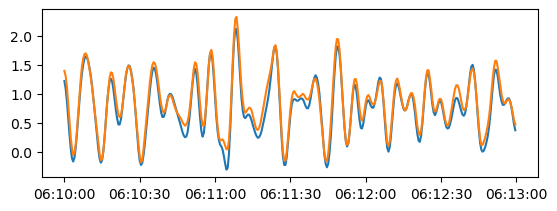

In [67]:
# window and sync time series



"posmv and vectornav indices for requested UTC DateTime start and epoch length TimePeriod"
function daylimits(utcdt::DateTime=DateTime(2024,6,1,6,0,0), epoch::Period=Minute(3), leapseconds=18)
    post = findfirst( posmvdt .>= utcdt )
    poen = findlast(  posmvdt .<= utcdt + epoch )
    vnst = findfirst( vndt    .>= utcdt + Second(leapseconds) ) # view +18 leapseconds forward to agree with UTC
    vnen = findlast(  vndt    .<= utcdt + Second(leapseconds) + epoch )
    post, poen, vnst, vnen
end

sample_factor = 9.94 #9.933333 # 9.95 not quite 10 = 20 Hz / 2 Hz
# Vn actually samples slightly slower than 10x the speed of POSMV
# so stepping by 10 Vn gets ahead of alignment with POSMV.
# Need to advance one index less (9 rather than 10) every 167 samples

# example time series synced by hand in vectornav.ipynb
post, poen, vnst, vnen = daylimits(DateTime(2024,6,1,6,10,0), Minute(3)) # June 1 1st day of Vn2
# this example window has a lag of ~20 s (`vectornav.ipynb`) 
# substract 20 s from vndt to match same signal at same time
# indices vnst:vnen already shift for the 18 leapseconds;
# at this time, need to shift forward 40 indices for the 2 s.
vn_offset = 40
# indices for Vn that line up with POSMV
vv = round.(Integer, range(vn_offset+vnst, step=sample_factor, length=poen-post+1))

# plot demonstrates that it's synced
clf()
subplot(2,1,1)
plot(posmvdt[post:poen], Pashr[:pitch][post:poen])
plot(posmvdt[post:poen], Vn[:Roll][vv], label="VectorNav")
gcf()

In [68]:
"solve for moments L by regression"
solve_L(w, V) = anom(V, dims=2) \ anom(w, dims=1) 
#                   3xn               nx1

#= Were both axes of the lidar strapped down, 
# the lidar would be in the ship's pitched and rolled coordinate system.
# But we have no w_lidar from the VectorNav for this time.

u_ship_in_lidar_frame = RotXY(ϕ, θ) * [0,0, w_ship]
w = w_lidar - u_ship_in_lidar_frame[:, 3]
solve_L(w, w_angles(θ, ϕ)) # completely strapped-down
=#

solve_L

If pitch is strapped down, but roll is stabilized, 
then set roll $\phi=0$ to rotation matrices ($\sin\phi=0, \cos\phi=1$) into the partly stabilized lidar coordinate system.
Since the ship is still moving, linear velocities at the lidar are still induced by the nonzero pitch and roll angular rates:
    
    V = w_angles(θ, 0, fft_derivative(θ)/dt, fft_derivative(ϕ)/dt)

In [84]:
# for roll corrected but pitch strapped down
# this is the case for leg 2 part 2
Vl2p2(θ, ϕ) = w_angles(θ, 0, fft_derivative(θ)/dt, fft_derivative(ϕ)/dt)
w_ship_in_lidar_frame = [ (RotY(θ[p]) * [0,0, w_ship[p]])[3] for p in post:poen ]

360-element Vector{Float32}:
  0.020618742
  0.0
 -0.045137856
 -0.10802229
 -0.15237337
 -0.14973009
 -0.079516485
  0.03942339
  0.19900084
  0.35911837
  ⋮
 -0.13349257
 -0.12588242
 -0.121164024
 -0.121164024
 -0.13048749
 -0.1449672
 -0.17212608
 -0.18722934
 -0.19578873

In [105]:
w = w_lidar[vv] - w_ship_in_lidar_frame
V = stack( Vl2p2(θ[post:poen], ϕ[post:poen]) )
L = solve_L(w, V)
# same as
# pd(w) / pd(V)

3-element Vector{Float64}:
 -46.65243154913796
   4.785762931079105
  41.86666861805886

In [ ]:
# deprecated

w0 = Pashr[:heave] # sign?
# heave +down for VectorNav
# need +down right-handed coordinate system for rotations

a = 
v = [ϕ, θ]
# then the heave in the lidar coordinate system is
w_lidar = RotXY(v...)*[0, 0, w0 + a*v]



# then the heave in the lidar coordinate system is
w_lidar = RotY(θ)*( w0 + a*v )